In [1]:
import pywt

from netCDF4 import Dataset
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, matthews_corrcoef, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

2024-08-24 15:16:39.478954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-24 15:16:39.492573: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-24 15:16:39.496740: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-24 15:16:39.506790: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-24 15:16:40.284194: W tensorflow/compiler/tf2

## Input Data

In [2]:
dataset = xr.open_dataset("../data/dataset_raw2_overlap.nc")
dataset

<xarray.Dataset> Size: 804MB
Dimensions:            (samples: 409, time_steps: 15361, channels: 16)
Coordinates:
  * samples            (samples) int64 3kB 0 1 2 3 4 5 ... 404 405 406 407 408
Dimensions without coordinates: time_steps, channels
Data variables:
    signal             (samples, time_steps, channels) float64 804MB ...
    label              (samples) int64 3kB ...
    segments           (samples) int64 3kB ...
    patient_names      (samples) <U8 13kB ...
    recording_numbers  (samples) int64 3kB ...

In [9]:
def min_max(m):
        min_val = np.min(m)
        max_val = np.max(m)

        return (m - min_val) / (max_val - min_val)

In [10]:
xx = dataset["signal"].to_numpy()
xx.shape

(409, 15361, 16)

In [11]:
xm = min_max(xx)
xm.shape

(409, 15361, 16)

In [13]:
xm[0, :, 1]

array([0.50569655, 0.50725144, 0.50601467, ..., 0.48146879, 0.48270199,
       0.48428905])

In [21]:
df = dataset[["label", "patient_names", "samples"]].to_dataframe()

In [22]:
df.value_counts().sort_index()

label  patient_names
0      amer             25
       dhelal           32
       mahmud           20
       majdolin         26
       omran            25
1      bader            37
       deena             4
       duaa             11
       mada             24
       mohammed         30
       nour             29
       omar             68
       saud             20
       shahad           34
       yahia            24
Name: count, dtype: int64

In [28]:
test_dataset = dataset.sel(samples=df[df["patient_names"].isin(["mahmud", "mada", "saud"])].index.tolist())
train_dataset = dataset.sel(samples=df[~df["patient_names"].isin(["mahmud", "mada", "saud"])].index.tolist())

X_train = train_dataset["signal"].to_numpy()
y_train = train_dataset["label"].to_numpy()

X_test = test_dataset["signal"].to_numpy()
y_test = test_dataset["label"].to_numpy()

In [29]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1]), array([108, 237])), (array([0, 1]), array([20, 44])))

In [30]:
pywt.wavelist(kind="discrete")

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'haar',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',
 'rbio3.3',
 'rbio3.5',
 'rbio3.7',
 'rbio3.9',
 'rbio4.4',
 'rbio5.5',
 'rbio6.8',
 'sym2',
 'sym3',
 'sym4',
 'sym5',
 'sym6',
 'sym7',
 'sym8',
 'sym9',
 'sym10',
 'sym11',
 'sym12',
 'sym13',

In [7]:
# perform decomposition
X_train_dec = pywt.wavedec(X_train, "bior2.6", axis=1, level=5)
X_test_dec = pywt.wavedec(X_test, "bior2.6", axis=1, level=5)

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices(({f"coeff_{i}":X_train_dec[i] for i in range(len(X_train_dec))}, y_train)).shuffle(X_train.shape[0]).batch(8)
test_ds = tf.data.Dataset.from_tensor_slices(({f"coeff_{i}":X_test_dec[i] for i in range(len(X_test_dec))}, y_test)).batch(8)

I0000 00:00:1724480120.177710  248615 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724480120.206711  248615 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724480120.206820  248615 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724480120.208054  248615 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724480120.208098  248615 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [9]:
train_ds, test_ds

(<_BatchDataset element_spec=({'coeff_0': TensorSpec(shape=(None, 492, 16), dtype=tf.float64, name=None), 'coeff_1': TensorSpec(shape=(None, 492, 16), dtype=tf.float64, name=None), 'coeff_2': TensorSpec(shape=(None, 972, 16), dtype=tf.float64, name=None), 'coeff_3': TensorSpec(shape=(None, 1931, 16), dtype=tf.float64, name=None), 'coeff_4': TensorSpec(shape=(None, 3850, 16), dtype=tf.float64, name=None), 'coeff_5': TensorSpec(shape=(None, 7687, 16), dtype=tf.float64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_BatchDataset element_spec=({'coeff_0': TensorSpec(shape=(None, 492, 16), dtype=tf.float64, name=None), 'coeff_1': TensorSpec(shape=(None, 492, 16), dtype=tf.float64, name=None), 'coeff_2': TensorSpec(shape=(None, 972, 16), dtype=tf.float64, name=None), 'coeff_3': TensorSpec(shape=(None, 1931, 16), dtype=tf.float64, name=None), 'coeff_4': TensorSpec(shape=(None, 3850, 16), dtype=tf.float64, name=None), 'coeff_5': TensorSpec(shape=(None, 7687, 16), dtype

## Create Model

In [10]:
# create inputs
inputs = []

for i, coeff in enumerate(X_train_dec):
    inputs.append(tf.keras.layers.Input(shape=(coeff.shape[1], coeff.shape[2],), name=f"coeff_{i}"))

In [11]:
class ConvolutionalBlock(tf.keras.Model):
    def __init__(self, kernel_size=128):
        super(ConvolutionalBlock, self).__init__()
        self.conv1a = tf.keras.layers.Conv1D(64, kernel_size=kernel_size, padding="same")
        self.bn1a = tf.keras.layers.BatchNormalization()

        self.conv2a = tf.keras.layers.Conv1D(64, kernel_size=kernel_size, padding="same")
        self.bn2a = tf.keras.layers.BatchNormalization()

        # self.conv3a = tf.keras.layers.Conv1D(64, kernel_size=kernel_size, padding="same")
        # self.bn3a = tf.keras.layers.BatchNormalization()

        self.convId = tf.keras.layers.Conv1D(64, kernel_size=kernel_size, padding="same")

        self.out_pool = tf.keras.layers.MaxPooling1D(pool_size=8, strides=4)

    def call(self, inputs, training=False):
        x = self.conv1a(inputs, training=training)
        x = self.bn1a(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2a(x, training=training)
        x = self.bn2a(x, training=training)
        # x = tf.nn.relu(x)

        # x = self.conv3a(x, training=training)
        # x = self.bn3a(x, training=training)
        # x = tf.nn.relu(x)

        x += self.convId(inputs, training=training)
        x = tf.nn.relu(x)

        x = self.out_pool(x, training=training)
        
        return x

In [12]:
# cA5
cA5 = ConvolutionalBlock(kernel_size=64)(inputs[0])

# cD5
cD5 = ConvolutionalBlock(kernel_size=64)(inputs[1])

# cD4
cD4 = ConvolutionalBlock(kernel_size=128)(inputs[2])

# cD3
cD3 = ConvolutionalBlock(kernel_size=128)(inputs[3])

# cD2
cD2 = ConvolutionalBlock(kernel_size=256)(inputs[4])

# cD1
cD1 = ConvolutionalBlock(kernel_size=256)(inputs[5])

# concat features
conc = tf.keras.layers.Concatenate(axis=1)([cA5, cD5, cD4, cD3, cD2, cD1])

# classification layer
# x = tf.keras.layers.Flatten()(conc)
x = tf.keras.layers.GlobalMaxPooling1D()(conc)
x = tf.keras.layers.Dense(1024, activation="relu")(x)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ coeff_0             │ (None, 492, 16)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coeff_1             │ (None, 492, 16)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coeff_2             │ (None, 972, 16)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coeff_3             │ (None, 1931, 16)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coeff_4             │ (None, 3850, 16)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coeff_5             │ (None, 7687, 16)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convolutional_block │ (None, 122, 64)   │    393,920 │ coeff_0[0][0]     │
│ (ConvolutionalBloc… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convolutional_bloc… │ (None, 122, 64)   │    393,920 │ coeff_1[0][0]     │
│ (ConvolutionalBloc… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convolutional_bloc… │ (None, 242, 64)   │    787,136 │ coeff_2[0][0]     │
│ (ConvolutionalBloc… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convolutional_bloc… │ (None, 481, 64)   │    787,136 │ coeff_3[0][0]     │
│ (ConvolutionalBloc… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convolutional_bloc… │ (None, 961, 64)   │  1,573,568 │ coeff_4[0][0]     │
│ (ConvolutionalBloc… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convolutional_bloc… │ (None, 1920, 64)  │  1,573,568 │ coeff_5[0][0]     │
│ (ConvolutionalBloc… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3848, 64)  │          0 │ convolutional_bl… │
│ (Concatenate)       │                   │            │ convolutional_bl… │
│                     │                   │            │ convolutional_bl… │
│                     │                   │            │ convolutional_bl… │
│                     │                   │            │ convolutional_bl… │
│                     │                   │            │ convolutional_bl… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ concatenate[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │     66,560 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      1,025 │ dense[0][0]     

 Total params: 5,576,833 (21.27 MB)

 Trainable params: 5,575,297 (21.27 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [31]:
# mp = tf.keras.utils.model_to_dot(model, show_layer_names=True, show_shapes=True, dpi=80)
# with open("model_plot.dot", "w") as f:
#     f.write(mp.to_string())

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, dpi=80)

NameError: name 'model' is not defined

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # loss=tf.keras.losses.BinaryFocalCrossentropy(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
])

In [16]:
log_dir = "logs/fit/" + "dwt_bior26_5-ds-60_25_overlap" #datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=20, start_from_epoch=30, restore_best_weights=True)

history = model.fit(train_ds, epochs=100, validation_data=test_ds, callbacks=[tensorboard_callback, earlystop])

Epoch 1/100


I0000 00:00:1724480130.122992  248757 service.cc:146] XLA service 0x7f34e008e2b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724480130.123033  248757 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-08-24 13:15:30.368880: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-24 13:15:31.346119: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 00:00:1724480137.932241  248757 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1724480138.250327  248757 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6659 - auc: 0.5362 - fn: 7.3529 - fp: 38.5882 - loss: 0.7813 - prc: 0.7118 - precision: 0.6812 - recall: 0.8745 - tn: 5.9118 - tp: 88.1471

E0000 00:00:1724480164.951210  248757 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1724480165.230537  248757 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-08-24 13:16:05.480777: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng5{} for conv (f32[2,64,1,3851]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,64,1,3850]{3,2,1,0}, f32[64,64,1,256]{3,2,1,0}), window={size=1x256 pad=0_0x127_127}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
E0000 00:00:172448

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.6660 - auc: 0.5363 - fn: 7.4857 - fp: 39.7143 - loss: 0.7788 - prc: 0.7124 - precision: 0.6816 - recall: 0.8763 - tn: 5.9714 - tp: 90.6571

E0000 00:00:1724480180.074491  248755 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1724480180.314497  248755 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1724480180.554386  248755 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-08-24 13:16:20.714868: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng13{} for conv (f32[8,64,1,3850]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,16,1,4105]{3,2,1,0}, f32[64,16,1,256]{3,2,1,0}, f32[64]{0}, f32[8,64,1,3850]{3,2,1,0}), window={size=1x256}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queu

35/35 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.6662 - auc: 0.5364 - fn: 7.6111 - fp: 40.7778 - loss: 0.7764 - prc: 0.7129 - precision: 0.6819 - recall: 0.8779 - tn: 6.0278 - tp: 93.0278 - val_accuracy: 0.6889 - val_auc: 0.5376 - val_fn: 0.0000e+00 - val_fp: 42.0000 - val_loss: 0.6753 - val_prc: 0.7457 - val_precision: 0.6889 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 93.0000
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.7633 - auc: 0.6629 - fn: 6.1111 - fp: 33.3889 - loss: 0.5382 - prc: 0.8500 - precision: 0.7737 - recall: 0.9486 - tn: 10.8056 - tp: 97.1389 - val_accuracy: 0.6889 - val_auc: 0.5699 - val_fn: 0.0000e+00 - val_fp: 42.0000 - val_loss: 0.6816 - val_prc: 0.7777 - val_precision: 0.6889 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 93.0000
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - accuracy: 0.7475 - auc: 0.7917 - fn: 9.6111 - fp: 28.7222 - loss: 0.5257 - prc: 0.8677 - precision: 0.7498 - recall: 0.9210 - tn: 21.0833 - tp: 

In [26]:
model.save("test.keras")

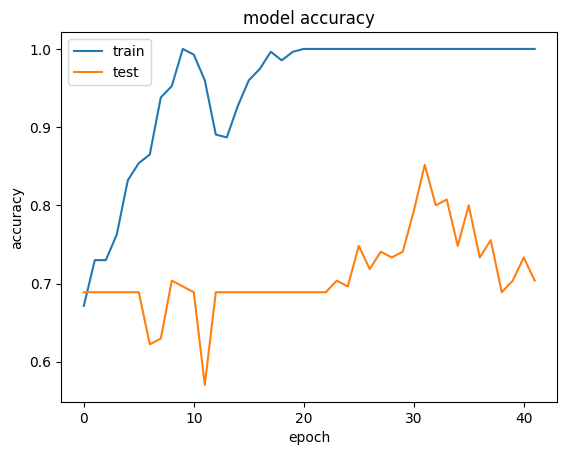

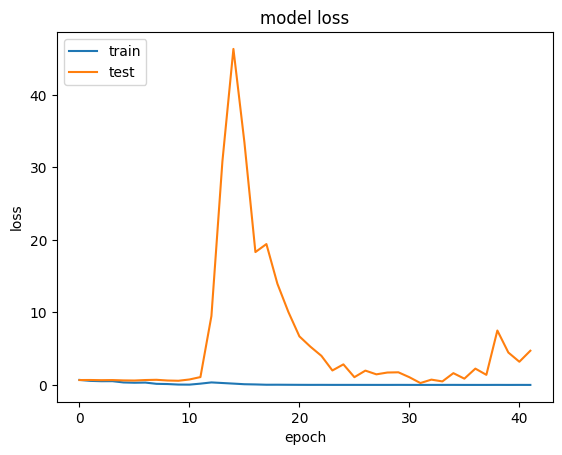

In [21]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluate

In [22]:
model.evaluate(test_ds)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8226 - auc: 0.8954 - fn: 2.0000 - fp: 10.6667 - loss: 0.3226 - prc: 0.9803 - precision: 0.8230 - recall: 0.9539 - tn: 13.0000 - tp: 49.7778


[0.26120439171791077,
 90.0,
 17.0,
 25.0,
 3.0,
 0.8518518805503845,
 0.84112149477005,
 0.9677419066429138,
 0.9562212228775024,
 0.9814231395721436]

In [23]:
y_pred = model.predict(test_ds) > 0.5

print("MCC:", np.round(matthews_corrcoef(y_test, y_pred), 4))
print("Accuracy:", np.round(accuracy_score(y_test, y_pred), 4))
print("Precision:", np.round(precision_score(y_test, y_pred), 4))
print("Recall:", np.round(recall_score(y_test, y_pred), 4))
print("F1:", np.round(f1_score(y_test, y_pred), 4))

print(classification_report(y_test, y_pred))

 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
MCC: 0.6428
Accuracy: 0.8519
Precision: 0.8411
Recall: 0.9677
F1: 0.9
              precision    recall  f1-score   support

           0       0.89      0.60      0.71        42
           1       0.84      0.97      0.90        93

    accuracy                           0.85       135
   macro avg       0.87      0.78      0.81       135
weighted avg       0.86      0.85      0.84       135



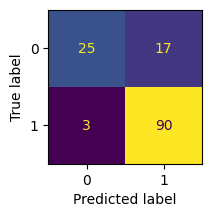

In [24]:
fig, ax = plt.subplots(figsize=(2, 2))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, colorbar=False)